In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from geopandas import GeoDataFrame

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\omkarp\\Downloads\\DataFinal\\')

# Density_Temporal_trip counts

In [2]:
points = gpd.read_file('Gdata_Sto.shp')
points = points.drop(columns=['FID_UTM_St','o_lat','o_lng','duration','distance','speed', 'o_times','Dated', 'weekday'])
points = points.rename(columns={'FID_Grid_D':'FID_grid','day_cats':'Week_cat','Pop22':'Pop'})
points.head(2)

,hour,month,date,seasons,Week_cat,FID_grid,Empl,Pop,Net_Inc,TVeh,geometry
0,14.0,Jan,19.0,Winter,Weekday,19,345.0,376.0,168.0,172.0,POINT (153789.596 6574412.047)
1,8.0,Jan,13.0,Winter,Weekday,20,373.0,407.0,176.0,181.0,POINT (154293.711 6574422.358)


In [3]:
points['trip_count'] = 1
data = points.groupby(['FID_grid','Pop','Empl','Net_Inc','TVeh','seasons','Week_cat']).agg({'trip_count': 'sum'}).reset_index()
data = data[data['trip_count']>4]
data.sort_values(by=["FID_grid"], inplace = True)
data.head()

,FID_grid,Pop,Empl,Net_Inc,TVeh,seasons,Week_cat,trip_count
1,9,832.0,738.0,157.0,332.0,Winter,Weekday,7
3,10,887.0,809.0,177.0,358.0,Winter,Weekday,34
4,10,887.0,809.0,177.0,358.0,Winter,Weekend,18
9,17,158.0,139.0,75.0,83.0,Winter,Weekday,35
11,18,193.0,172.0,90.0,97.0,Winter,Weekday,26


In [4]:
print('Max trip count in a subdivision: ', data['trip_count'].max())
data.info()

Max trip count in a subdivision:  26333
<class 'pandas.core.frame.DataFrame'>
Index: 2990 entries, 1 to 3422
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID_grid    2990 non-null   int64  
 1   Pop         2990 non-null   float64
 2   Empl        2990 non-null   float64
 3   Net_Inc     2990 non-null   float64
 4   TVeh        2990 non-null   float64
 5   seasons     2990 non-null   object 
 6   Week_cat    2990 non-null   object 
 7   trip_count  2990 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 210.2+ KB


# Diversity (tdidf)

## Building POIs

In [5]:
# Building POIs
os.chdir('C:\\Users\\omkarp\\Downloads\\Stodata\\POI\\')
pois1 = gpd.read_file('POI_bldgs.shp')
pois1 = pois1.drop(columns=['osm_id','code', 'fclass','geometry','name','OBJECTID','FID_POI_Bl','ORIG_FID','ID_grid'])
pois1.head()

,type,FID_grid
0,apartments,26
1,kindergarten,26
2,None,26
3,None,30
4,apartments,26


In [6]:
pois1['type'].unique()

array(['apartments', 'kindergarten', None, 'house', 'residential',
       'commercial', 'transportation', 'detached', 'garage', 'parking',
       'roof', 'retail', 'terrace', 'power', 'carport', 'shed',
       'semidetached_house', 'office', 'industrial', 'service', 'school',
       'tower', 'farm_auxiliary', 'sports_hall', 'warehouse', 'garages',
       'hospital', 'riding_hall', 'church', 'barn', 'sports_centre',
       'stable', 'public', 'bungalow', 'construction', 'kiosk',
       'train_station', 'toilets', 'hotel', 'allotment_house', 'stadium',
       'civic', 'semi', 'bridge', 'railway_station', 'garage_shed',
       'cabin', 'power_station', 'storage_tank', 'farm', 'chimney',
       'ship', 'grandstand', 'elevator', 'chapel', 'greenhouse',
       'houseboat', 'cathedral', 'government', 'mosque', 'hut', 'theatre',
       'windmill', 'container', 'boat', 'university', 'depot', 'gazebo',
       'museum', 'palace', 'concert_hall', 'nursery', 'cafe', 'hangar',
       'restaurant', '

In [7]:
def merge_fclasses(fclass):
    if fclass in ['bungalow','allotment_house','mixed','semidetached_house','detached', 'dormitory','hut','semi','house',
                  'residential','apartments','cabin','shelter']:
        return 'LUP_Resi'
    elif fclass in ['retail','supermarket','hotel','hangar','factory','store','industrial','office','nursery','commercial',
                    'restaurant','warehouse','cafe']:
        return 'LUP_Comm'
    elif fclass in ['sports_hall','park','theatre','church','religious','kiosk','cathedral','social_facility','subway_station',
                    'cultural','palace','gazebo','sport', 'sports_centre','theatre','stadium','ruins','synagogue','chapel',
                    'pavilion','mosque','cinema','museum','conference_centre','concert_hall','riding_hall', 'houseboat',
                    'boathouse']:
        return 'LUP_Recre'
    elif fclass in ['university','school','college','hostel','kindergarten','riding_school']:
        return 'LUP_Edu'
    elif fclass in ['train_station','civic','library','community_centre','bank','atm','post_office','government','public','railway_station','depot','observatory','embassy', 'parking']:
        return 'LUP_Public'
    elif fclass in ['hospital', 'clinic']:
        return 'LUP_Health'
    else:
        return 'LUP_Other'
    
pois1['major_clas'] = pois1['type'].apply(merge_fclasses)
pois1.head()

,type,FID_grid,major_clas
0,apartments,26,LUP_Resi
1,kindergarten,26,LUP_Edu
2,None,26,LUP_Other
3,None,30,LUP_Other
4,apartments,26,LUP_Resi


In [8]:
pois1['count']=1
result1 = pois1.groupby(['FID_grid', 'major_clas']).agg({'count': 'sum'})
result1 = result1.reset_index(drop = False)
result1.head(12)

,FID_grid,major_clas,count
0,0,LUP_Other,60
1,0,LUP_Recre,1
2,0,LUP_Resi,11
3,1,LUP_Comm,4
4,1,LUP_Edu,4
5,1,LUP_Other,61
6,2,LUP_Comm,2
7,2,LUP_Other,14
8,2,LUP_Resi,9
9,3,LUP_Other,10


In [9]:
result1['LUP_Comm'] = result1['count'][result1['major_clas'] == 'LUP_Comm']
result1['LUP_Other'] = result1['count'][result1['major_clas'] == 'LUP_Other']
result1['LUP_Recre'] = result1['count'][result1['major_clas'] == 'LUP_Recre']
result1['LUP_Public'] = result1['count'][result1['major_clas'] == 'LUP_Public']
result1['LUP_Resi'] = result1['count'][result1['major_clas'] == 'LUP_Resi']
result1['LUP_Edu'] = result1['count'][result1['major_clas'] == 'LUP_Edu']
result1['LUP_Health'] = result1['count'][result1['major_clas'] == 'LUP_Health']

result1 = result1.drop(columns=['major_clas', 'count'])
result1

,FID_grid,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health
0,0,NaN,60.0,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,11.0,NaN,NaN
3,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...
2334,916,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2335,916,NaN,33.0,NaN,NaN,NaN,NaN,NaN
2336,916,NaN,NaN,NaN,NaN,20.0,NaN,NaN
2337,917,NaN,16.0,NaN,NaN,NaN,NaN,NaN


In [10]:
result1 = result1.groupby(['FID_grid']).sum()
result1

,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health
FID_grid,,,,,,,
0,0.0,60.0,1.0,0.0,11.0,0.0,0.0
1,4.0,61.0,0.0,0.0,0.0,4.0,0.0
2,2.0,14.0,0.0,0.0,9.0,0.0,0.0
3,0.0,10.0,0.0,0.0,27.0,0.0,0.0
4,1.0,11.0,0.0,0.0,17.0,1.0,0.0
...,...,...,...,...,...,...,...
913,0.0,2.0,0.0,0.0,37.0,0.0,0.0
914,0.0,17.0,0.0,0.0,4.0,3.0,0.0
915,0.0,36.0,2.0,0.0,51.0,0.0,0.0


In [11]:
result1.sum()

LUP_Comm       1271.0
LUP_Other     14088.0
LUP_Recre       293.0
LUP_Public      125.0
LUP_Resi      16510.0
LUP_Edu         615.0
LUP_Health       66.0
dtype: float64

## Landuse POIs

In [12]:
os.chdir('C:\\Users\\omkarp\\Downloads\\Stodata\\POI\\')
pois2 = gpd.read_file('POI_LandUse.shp')
pois2 = pois2.drop(columns=['osm_id','code','geometry','name','OBJECTID','OBJECTID_1','FID_LandUs','ID_grid','OBJECTID'])
pois2.head()

,fclass,FID_grid
0,toilet,30
1,tourist_info,29
2,bench,29
3,picnic_site,31
4,artwork,26


In [13]:
def merge_fclasses(fclass):
    if fclass in ['shelter','chalet']:
        return 'LUP_Resi'
    elif fclass in ['hotel','restaurant','bicycle_shop','fast_food','cafe','bar','supermarket','convenience','department_store',
                    'mall','pub','motel','outdoor_shop','bookshop','clothes','optician','car_rental','nightclub','bakery',
                    'laundry','hairdresser','beverages','florist','travel_agent','biergarten','furniture_shop','stationery',
                    'recycling_clothes','bicycle_rental','food_court','beauty_shop','doityourself','video_shop','sports_shop',
                    'mobile_phone_shop','shoe_shop','jeweller','toy_shop','car_dealership','gift_shop','greengrocer','butcher',
                    'computer_shop','vending_parking','vending_machine','vending_any','car_wash']:
        return 'LUP_Comm'
    elif fclass in ['garden_centre','park','theatre','tourist_info','cinema','playground','sports_centre','attraction',
                    'picnic_site','zoo','fountain','viewpoint','artwork','kiosk','archaeological','ruins','arts_centre',
                    'drinking_water','car_sharing','theme_park']:
        return 'LUP_Recre'
    elif fclass in ['university','school','college','hostel','kindergarten','riding_school']:
        return 'LUP_Edu'
    elif fclass in ['community_centre','bank','atm','post_office','museum','monument','memorial,''toilet','library',
                    'embassy','police','post_box','fire_station','courthouse']:
        return 'LUP_Public'
    elif fclass in ['hospital', 'clinic']:
        return 'LUP_Health'
    else:
        return 'LUP_Other'
    
pois2['major_clas'] = pois2['fclass'].apply(merge_fclasses)
pois2.head()

,fclass,FID_grid,major_clas
0,toilet,30,LUP_Other
1,tourist_info,29,LUP_Recre
2,bench,29,LUP_Other
3,picnic_site,31,LUP_Recre
4,artwork,26,LUP_Recre


In [14]:
pois2['count']=1
result2 = pois2.groupby(['FID_grid', 'major_clas']).agg({'count': 'sum'})
result2 = result2.reset_index(drop = False)
result2.head(12)

,FID_grid,major_clas,count
0,0,LUP_Other,1
1,2,LUP_Comm,2
2,2,LUP_Other,2
3,2,LUP_Recre,1
4,3,LUP_Comm,1
5,3,LUP_Recre,1
6,4,LUP_Comm,4
7,4,LUP_Other,1
8,4,LUP_Public,1
9,5,LUP_Comm,2


In [15]:
result2['LUP_Comm'] = result2['count'][result2['major_clas'] == 'LUP_Comm']
result2['LUP_Other'] = result2['count'][result2['major_clas'] == 'LUP_Other']
result2['LUP_Recre'] = result2['count'][result2['major_clas'] == 'LUP_Recre']
result2['LUP_Public'] = result2['count'][result2['major_clas'] == 'LUP_Public']
result2['LUP_Resi'] = result2['count'][result2['major_clas'] == 'LUP_Resi']
result2['LUP_Edu'] = result2['count'][result2['major_clas'] == 'LUP_Edu']
result2['LUP_Health'] = result2['count'][result2['major_clas'] == 'LUP_Health']

result2 = result2.drop(columns=['major_clas', 'count'])
result2

,FID_grid,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health
0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,2.0,NaN,NaN,NaN,NaN,NaN
3,2,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2161,914,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2162,914,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2163,914,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2164,916,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [16]:
result2 = result2.groupby(['FID_grid']).sum()
result2

,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health
FID_grid,,,,,,,
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,1.0,0.0,1.0,0.0,0.0,0.0
5,2.0,3.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
910,1.0,0.0,0.0,0.0,0.0,0.0,0.0
912,0.0,2.0,0.0,0.0,0.0,0.0,0.0
913,0.0,2.0,2.0,0.0,0.0,0.0,0.0


In [17]:
result = result1.add(result2, fill_value=0)
result

,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health
FID_grid,,,,,,,
0,0.0,61.0,1.0,0.0,11.0,0.0,0.0
1,4.0,61.0,0.0,0.0,0.0,4.0,0.0
2,4.0,16.0,1.0,0.0,9.0,0.0,0.0
3,1.0,10.0,1.0,0.0,27.0,0.0,0.0
4,5.0,12.0,0.0,1.0,17.0,1.0,0.0
...,...,...,...,...,...,...,...
913,0.0,4.0,2.0,0.0,37.0,0.0,0.0
914,1.0,17.0,1.0,1.0,4.0,3.0,0.0
915,0.0,36.0,2.0,0.0,51.0,0.0,0.0


In [18]:
result.sum()

LUP_Comm       8390.0
LUP_Other     18665.0
LUP_Recre      1785.0
LUP_Public      933.0
LUP_Resi      16541.0
LUP_Edu         852.0
LUP_Health      115.0
dtype: float64

## Land use ratio (tdidf)

In [19]:
mix=result.loc[:,['LUP_Resi','LUP_Comm','LUP_Edu','LUP_Recre','LUP_Public','LUP_Health','LUP_Other']]
weight = list(mix.sum(axis=0).sum()/mix.sum(axis=0))
c = np.log(weight)
# print(c)
mix.iloc[0:len(mix),0] = mix.iloc[0:len(mix),0]*c[0]
mix.iloc[0:len(mix),1] = mix.iloc[0:len(mix),1]*c[1]
mix.iloc[0:len(mix),2] = mix.iloc[0:len(mix),2]*c[2]
mix.iloc[0:len(mix),3] = mix.iloc[0:len(mix),3]*c[3]
mix.iloc[0:len(mix),4] = mix.iloc[0:len(mix),4]*c[4]
mix.iloc[0:len(mix),5] = mix.iloc[0:len(mix),5]*c[5]
mix.iloc[0:len(mix),6] = mix.iloc[0:len(mix),6]*c[6]
mix['all'] = mix.sum(axis=1)
mix.loc[:,'LUP_Resi':'LUP_Other'] = mix.loc[:,'LUP_Resi':'LUP_Other'].div(mix['all'], axis=0)+0.00001
mix = mix.astype(float)
mix.fillna(0, inplace=True)
mix.describe(include='all')
mix2 = mix
def func (x):
    y = x*np.log(x)
    return y
mix2 = mix2.loc[:,'LUP_Resi':'LUP_Other'].applymap(func)/(-np.log(5))
mix2['entropy'] = mix2.loc[:,'LUP_Resi':'LUP_Other'].sum(axis=1)
mix['entropy'] = mix2['entropy']
mix['Resi_lur'] = mix['LUP_Resi']
mix['Comm_lur'] = mix['LUP_Comm']
mix['Edu_lur'] = mix['LUP_Edu']
mix['Recre_lur'] = mix['LUP_Recre']
mix['Public_lur'] = mix['LUP_Public']
mix['Health_lur'] = mix['LUP_Health']
mix['Other_lur'] = mix['LUP_Other']
mix = mix.drop(['LUP_Resi', 'LUP_Comm', 'LUP_Edu', 'LUP_Recre', 'LUP_Public','LUP_Health', 'LUP_Other','all'], axis=1)
mix = mix.reset_index(drop=False)
mix

,FID_grid,entropy,Resi_lur,Comm_lur,Edu_lur,Recre_lur,Public_lur,Health_lur,Other_lur
0,0,0.385460,0.161529,0.000010,0.000010,0.045821,0.000010,0.00001,0.792680
1,1,0.483171,0.000010,0.086812,0.201635,0.000010,0.000010,0.00001,0.711583
2,2,0.785035,0.273860,0.200385,0.000010,0.094941,0.000010,0.00001,0.430855
3,3,0.578402,0.664774,0.040544,0.000010,0.076824,0.000010,0.00001,0.217898
4,4,0.902333,0.391599,0.189621,0.088096,0.000010,0.086104,0.00001,0.244631
...,...,...,...,...,...,...,...,...,...
853,913,0.403881,0.790953,0.000010,0.000010,0.133396,0.000010,0.00001,0.075682
854,914,0.945219,0.102520,0.042201,0.294014,0.079965,0.095795,0.00001,0.385565
855,915,0.542897,0.572408,0.000010,0.000010,0.070042,0.000010,0.00001,0.357580
856,916,0.639437,0.353982,0.058285,0.000010,0.055227,0.000010,0.00001,0.532546


In [20]:
# Merged LUP counts and LUR into main data
data = data.reset_index(drop=True)
data = data.merge(result, on='FID_grid', how='left')
data = data.merge(mix, on='FID_grid', how='left')
data.head()

,FID_grid,Pop,Empl,Net_Inc,TVeh,seasons,Week_cat,trip_count,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health,entropy,Resi_lur,Comm_lur,Edu_lur,Recre_lur,Public_lur,Health_lur,Other_lur
0,9,832.0,738.0,157.0,332.0,Winter,Weekday,7,2.0,30.0,2.0,0.0,2.0,0.0,0.0,0.568310,0.052529,0.086472,0.000010,0.163862,0.000010,0.00001,0.697177
1,10,887.0,809.0,177.0,358.0,Winter,Weekday,34,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699
2,10,887.0,809.0,177.0,358.0,Winter,Weekend,18,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699
3,17,158.0,139.0,75.0,83.0,Winter,Weekday,35,9.0,12.0,3.0,1.0,22.0,0.0,0.0,0.918671,0.363444,0.244780,0.000010,0.154628,0.061754,0.00001,0.175444
4,18,193.0,172.0,90.0,97.0,Winter,Weekday,26,0.0,91.0,2.0,0.0,94.0,0.0,0.0,0.507589,0.520001,0.000010,0.000010,0.034527,0.000010,0.00001,0.445502


## Transit Infra_hinder/enable (tdidf)

In [21]:
os.chdir('C:\\Users\\omkarp\\Downloads\\DataFinal\\')
data3 = gpd.read_file("Traffic_Infra_POIs.shp")
data3.head()

,FID_Traffi,OBJECTID,osm_id,code,fclass,name,FID_grid,Empl,Pop22,Net_Inc,TVeh,geometry
0,1967,1968,703514967,5204,crossing,None,26,601.0,688.0,178.0,259.0,POINT (18.11642 59.28374)
1,4554,4555,2282477416,5270,parking_bicycle,None,26,601.0,688.0,178.0,259.0,POINT (18.11492 59.28376)
2,3983,3984,1735457526,5204,crossing,None,25,528.0,608.0,165.0,222.0,POINT (18.11278 59.28391)
3,2323,2324,1069219386,5204,crossing,None,25,528.0,608.0,165.0,222.0,POINT (18.11358 59.28398)
4,9267,9268,9833233870,5270,parking_bicycle,None,25,528.0,608.0,165.0,222.0,POINT (18.11345 59.28404)


In [22]:
def classify_tranInfra(fclass):
    if fclass in ['traffic_signals', 'motorway_junction', 'slipway','weir','marina','lock_gate','stop']:
        return 'T_Hinder'
    elif fclass in ['crossing', 'turning_circle', 'mini_roundabout', 'parking_underground','parking_bicycle']:
        return 'T_Enable'
    else:
        return 'T_Other'

data3['major_class'] = data3['fclass'].apply(classify_tranInfra)
data3 = data3.drop(columns=['FID_Traffi','OBJECTID','osm_id','code','fclass','name','Empl','Pop22','Net_Inc',
                            'TVeh','geometry',])
data3.head()

,FID_grid,major_class
0,26,T_Enable
1,26,T_Enable
2,25,T_Enable
3,25,T_Enable
4,25,T_Enable


In [23]:
data3['count']=1
result4 = data3.groupby(['FID_grid', 'major_class']).agg({'count': 'sum'})
result4 = result4.reset_index(drop = False)
result4.head()

,FID_grid,major_class,count
0,0,T_Enable,11
1,0,T_Hinder,2
2,1,T_Enable,5
3,2,T_Enable,17
4,2,T_Hinder,4


In [24]:
result4['T_Enable_POI'] = result4['count'][result4['major_class'] == 'T_Enable']
result4['T_Hinder_POI'] = result4['count'][result4['major_class'] == 'T_Hinder']
result4['T_Other_POI'] = result4['count'][result4['major_class'] == 'T_Other']

result4 = result4.drop(columns=['major_class', 'count'])
result4 = result4.groupby(['FID_grid']).sum()
result4

,T_Enable_POI,T_Hinder_POI,T_Other_POI
FID_grid,,,
0,11.0,2.0,0.0
1,5.0,0.0,0.0
2,17.0,4.0,1.0
3,5.0,1.0,1.0
4,7.0,0.0,0.0
...,...,...,...
910,4.0,0.0,0.0
914,2.0,0.0,0.0
915,2.0,0.0,0.0


In [25]:
# TDIDF for transit
mix1=result4.loc[:,['T_Enable_POI','T_Hinder_POI','T_Other_POI']]
weight = list(mix1.sum(axis=0).sum()/mix1.sum(axis=0))
c = np.log(weight)
# print(c)
mix1.iloc[0:len(mix1),0] = mix1.iloc[0:len(mix1),0]*c[0]
mix1.iloc[0:len(mix1),1] = mix1.iloc[0:len(mix1),1]*c[1]
mix1.iloc[0:len(mix1),2] = mix1.iloc[0:len(mix1),2]*c[2]

mix1['all'] = mix1.sum(axis=1)
mix1.loc[:,'T_Enable_POI':'T_Other_POI'] = mix1.loc[:,'T_Enable_POI':'T_Other_POI'].div(mix1['all'], axis=0)+0.00001
mix1 = mix1.astype(float)
mix1.fillna(0, inplace=True)
mix1.describe(include='all')
mix2 = mix1
def func (x):
    y = x*np.log(x)
    return y
mix2 = mix2.loc[:,'T_Enable_POI':'T_Other_POI'].applymap(func)/(-np.log(5))
mix2['Tentropy'] = mix2.loc[:,'LUP_Resi':'LUP_Other'].sum(axis=1)
mix1['Tentropy'] = mix2['Tentropy']
mix1['T_Enable_LUR'] = mix1['T_Enable_POI']
mix1['T_Hinder_LUR'] = mix1['T_Hinder_POI']
mix1['T_Other_LUR'] = mix1['T_Other_POI']

mix1 = mix1.drop(['T_Enable_POI','T_Hinder_POI','T_Other_POI','all'], axis=1)
mix1 = mix1.reset_index(drop=False)
mix1

,FID_grid,Tentropy,T_Enable_LUR,T_Hinder_LUR,T_Other_LUR
0,0,0.0,0.412916,0.587104,0.000010
1,1,0.0,1.000010,0.000010,0.000010
2,2,0.0,0.275519,0.506961,0.217550
3,3,0.0,0.190535,0.297999,0.511496
4,4,0.0,1.000010,0.000010,0.000010
...,...,...,...,...,...
714,910,0.0,1.000010,0.000010,0.000010
715,914,0.0,1.000010,0.000010,0.000010
716,915,0.0,1.000010,0.000010,0.000010
717,916,0.0,0.000010,1.000010,0.000010


In [26]:
# Merged T LUP and LUR into main data
data = data.reset_index(drop=True)
data = data.merge(result4, on='FID_grid', how='left')
data = data.merge(mix1, on='FID_grid', how='left')
data.head()

,FID_grid,Pop,Empl,Net_Inc,TVeh,seasons,Week_cat,trip_count,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health,entropy,Resi_lur,Comm_lur,Edu_lur,Recre_lur,Public_lur,Health_lur,Other_lur,T_Enable_POI,T_Hinder_POI,T_Other_POI,Tentropy,T_Enable_LUR,T_Hinder_LUR,T_Other_LUR
0,9,832.0,738.0,157.0,332.0,Winter,Weekday,7,2.0,30.0,2.0,0.0,2.0,0.0,0.0,0.568310,0.052529,0.086472,0.000010,0.163862,0.000010,0.00001,0.697177,5.0,0.0,0.0,0.0,1.000010,0.000010,0.00001
1,10,887.0,809.0,177.0,358.0,Winter,Weekday,34,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001
2,10,887.0,809.0,177.0,358.0,Winter,Weekend,18,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001
3,17,158.0,139.0,75.0,83.0,Winter,Weekday,35,9.0,12.0,3.0,1.0,22.0,0.0,0.0,0.918671,0.363444,0.244780,0.000010,0.154628,0.061754,0.00001,0.175444,7.0,4.0,0.0,0.0,0.182869,0.817151,0.00001
4,18,193.0,172.0,90.0,97.0,Winter,Weekday,26,0.0,91.0,2.0,0.0,94.0,0.0,0.0,0.507589,0.520001,0.000010,0.000010,0.034527,0.000010,0.00001,0.445502,1.0,0.0,0.0,0.0,1.000010,0.000010,0.00001


# Design (Roads)

In [27]:
os.chdir('C:\\Users\\omkarp\\Downloads\\shp\\Stoshp\\Params\\')
datard = gpd.read_file("RoadsOSM.shp")
datard.head()

,OBJECTID,FID_gis_os,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,FID_grid,ID_grid,Shape_Leng,geometry
0,1,1,1240,5121,unclassified,Klensmedsvägen,None,B,30,0.0,F,F,76,76,351.732167,"MULTILINESTRING ((670282.657 6576930.061, 6702..."
1,2,1,1240,5121,unclassified,Klensmedsvägen,None,B,30,0.0,F,F,77,77,268.692293,"MULTILINESTRING ((670601.865 6576804.433, 6706..."
2,3,2,1241,5122,residential,Hyvelvägen,None,B,30,0.0,F,F,42,42,10.004868,"LINESTRING (670369.964 6576592.305, 670369.274..."
3,4,2,1241,5122,residential,Hyvelvägen,None,B,30,0.0,F,F,76,76,325.129770,"MULTILINESTRING ((670417.229 6576912.078, 6703..."
4,5,3,1242,5122,residential,Spikvägen,None,B,30,0.0,F,F,42,42,21.205681,"LINESTRING (670427.988 6576592.305, 670426.176..."


In [28]:
datard['fclass'].unique()

array(['unclassified', 'residential', 'tertiary', 'pedestrian', 'footway',
       'service', 'cycleway', 'secondary', 'path', 'steps',
       'living_street', 'tertiary_link', 'secondary_link',
       'motorway_link', 'motorway', 'primary', 'trunk', 'track_grade2',
       'primary_link', 'trunk_link', 'bridleway', 'track', 'track_grade4',
       'track_grade1', 'track_grade3', 'unknown'], dtype=object)

In [29]:
def merge_fclasses(fclass):
    if fclass in ['primary', 'motorway', 'trunk']:
        return 'Primary'
    elif fclass in ['secondary', 'primary_link', 'trunk_link', 'secondary_link', 'motorway_link']:
        return 'Secondary'
    elif fclass in ['tertiary', 'tertiary_link', 'residential', 'living_street', 'service']:
        return 'Tertiary'
    elif fclass in ['cycleway', 'bridleway', 'track']:
        return 'Cycleway'
    elif fclass in ['pedestrian', 'footway', 'path', 'steps', 'track_grade2', 'track_grade4', 'track_grade1', 
                    'track_grade3','unclassified','unknown']:
        return 'Pedestrian'
    else:
        return 'Other'   # May include nothing

datard['main_fclass'] = datard['fclass'].apply(merge_fclasses)
datard.head()

,OBJECTID,FID_gis_os,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,FID_grid,ID_grid,Shape_Leng,geometry,main_fclass
0,1,1,1240,5121,unclassified,Klensmedsvägen,None,B,30,0.0,F,F,76,76,351.732167,"MULTILINESTRING ((670282.657 6576930.061, 6702...",Pedestrian
1,2,1,1240,5121,unclassified,Klensmedsvägen,None,B,30,0.0,F,F,77,77,268.692293,"MULTILINESTRING ((670601.865 6576804.433, 6706...",Pedestrian
2,3,2,1241,5122,residential,Hyvelvägen,None,B,30,0.0,F,F,42,42,10.004868,"LINESTRING (670369.964 6576592.305, 670369.274...",Tertiary
3,4,2,1241,5122,residential,Hyvelvägen,None,B,30,0.0,F,F,76,76,325.129770,"MULTILINESTRING ((670417.229 6576912.078, 6703...",Tertiary
4,5,3,1242,5122,residential,Spikvägen,None,B,30,0.0,F,F,42,42,21.205681,"LINESTRING (670427.988 6576592.305, 670426.176...",Tertiary


In [30]:
result1 = datard.groupby(['FID_grid', 'main_fclass']).agg({'Shape_Leng': 'sum'})
result1 = result1.reset_index(drop = False)
result1.head(12)

,FID_grid,main_fclass,Shape_Leng
0,0,Cycleway,818.410684
1,0,Pedestrian,917.221179
2,0,Secondary,852.692989
3,0,Tertiary,2535.529207
4,1,Cycleway,1313.009764
5,1,Pedestrian,666.775852
6,1,Secondary,1711.314521
7,1,Tertiary,2086.348251
8,2,Cycleway,1299.480218
9,2,Pedestrian,945.193010


In [31]:
result1['Rd_Pri'] = result1['Shape_Leng'][result1['main_fclass'] == 'Primary']
result1['Rd_Sec'] = result1['Shape_Leng'][result1['main_fclass'] == 'Secondary']
result1['Rd_Ter'] = result1['Shape_Leng'][result1['main_fclass'] == 'Tertiary']
result1['Rd_Cyc'] = result1['Shape_Leng'][result1['main_fclass'] == 'Cycleway']
result1['Rd_Pedes'] = result1['Shape_Leng'][result1['main_fclass'] == 'Pedestrian']
result1['Rd_Other'] = result1['Shape_Leng'][result1['main_fclass'] == 'Other']
result1 = result1.drop(columns=['main_fclass', 'Shape_Leng'])
result1 = result1.groupby(['FID_grid']).sum().reset_index()
result1

,FID_grid,Rd_Pri,Rd_Sec,Rd_Ter,Rd_Cyc,Rd_Pedes,Rd_Other
0,0,0.000000,852.692989,2535.529207,818.410684,917.221179,0.0
1,1,0.000000,1711.314521,2086.348251,1313.009764,666.775852,0.0
2,2,566.758570,1988.977791,2595.773418,1299.480218,945.193010,0.0
3,3,822.543326,190.543860,2353.975103,1263.690076,670.158884,0.0
4,4,800.452789,0.000000,2746.882275,1395.796525,968.796234,0.0
...,...,...,...,...,...,...,...
882,913,0.000000,0.000000,630.362236,340.567165,1696.966686,0.0
883,914,0.000000,0.000000,322.227411,232.339096,2295.766041,0.0
884,915,0.000000,0.000000,2143.876994,167.352327,295.757246,0.0
885,916,0.000000,0.000000,1311.648207,340.938040,155.010519,0.0


In [32]:
result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FID_grid  887 non-null    int64  
 1   Rd_Pri    887 non-null    float64
 2   Rd_Sec    887 non-null    float64
 3   Rd_Ter    887 non-null    float64
 4   Rd_Cyc    887 non-null    float64
 5   Rd_Pedes  887 non-null    float64
 6   Rd_Other  887 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 48.6 KB


In [33]:
data = data.merge(result1, on='FID_grid', how='left')
data.head()

,FID_grid,Pop,Empl,Net_Inc,TVeh,seasons,Week_cat,trip_count,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health,entropy,Resi_lur,Comm_lur,Edu_lur,Recre_lur,Public_lur,Health_lur,Other_lur,T_Enable_POI,T_Hinder_POI,T_Other_POI,Tentropy,T_Enable_LUR,T_Hinder_LUR,T_Other_LUR,Rd_Pri,Rd_Sec,Rd_Ter,Rd_Cyc,Rd_Pedes,Rd_Other
0,9,832.0,738.0,157.0,332.0,Winter,Weekday,7,2.0,30.0,2.0,0.0,2.0,0.0,0.0,0.568310,0.052529,0.086472,0.000010,0.163862,0.000010,0.00001,0.697177,5.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2082.456266,419.872391,1439.900816,0.0
1,10,887.0,809.0,177.0,358.0,Winter,Weekday,34,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0
2,10,887.0,809.0,177.0,358.0,Winter,Weekend,18,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0
3,17,158.0,139.0,75.0,83.0,Winter,Weekday,35,9.0,12.0,3.0,1.0,22.0,0.0,0.0,0.918671,0.363444,0.244780,0.000010,0.154628,0.061754,0.00001,0.175444,7.0,4.0,0.0,0.0,0.182869,0.817151,0.00001,0.0,1111.702762,1324.557886,1320.841234,711.715352,0.0
4,18,193.0,172.0,90.0,97.0,Winter,Weekday,26,0.0,91.0,2.0,0.0,94.0,0.0,0.0,0.507589,0.520001,0.000010,0.000010,0.034527,0.000010,0.00001,0.445502,1.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,93.634200,2986.375820,1583.108650,348.374199,0.0


# Distance to transit (AreaProx)

In [34]:
os.chdir('C:\\Users\\omkarp\\Downloads\\shp\\Stoshp\\Params\\')
df = gpd.read_file("Stops_Prox.shp")
df.head()

,OBJECTID_1,FID_Stops_,OBJECTID,osm_id,code,fclass,name,BUFF_DIST,ORIG_FID,FID_grid,ID_grid,Shape_Area,geometry
0,1,1,1,161278,5603,tram_stop,Alviks strand,300.0,0,346,346,5287.807645,"POLYGON ((669801.864 6580187.819, 669788.349 6..."
1,2,1,1,161278,5603,tram_stop,Alviks strand,300.0,0,347,347,18.530901,"POLYGON ((669801.864 6580187.819, 669801.864 6..."
2,3,1,1,161278,5603,tram_stop,Alviks strand,300.0,0,380,380,2124.913924,"MULTIPOLYGON (((669555.610 6580192.310, 669512..."
3,4,1,1,161278,5603,tram_stop,Alviks strand,300.0,0,381,381,3450.668598,"POLYGON ((669810.017 6580192.310, 669801.864 6..."
4,5,4,6,29897897,5603,tram_stop,Ropsten,300.0,3,704,704,96.801623,"POLYGON ((676718.496 6584109.773, 676715.408 6..."


In [35]:
df = df.groupby('FID_grid')['Shape_Area'].agg('sum').to_frame()
df = df.reset_index(drop=False)
df = df.rename(columns={'Shape_Area': 'AreaProx'})
df.head()

,FID_grid,AreaProx
0,0,323957.054068
1,1,973162.801761
2,2,856942.995586
3,3,355537.501928
4,4,415996.418466


In [36]:
data = data.merge(df, on='FID_grid', how='left')
data = data.drop_duplicates()
data.head()

,FID_grid,Pop,Empl,Net_Inc,TVeh,seasons,Week_cat,trip_count,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health,entropy,Resi_lur,Comm_lur,Edu_lur,Recre_lur,Public_lur,Health_lur,Other_lur,T_Enable_POI,T_Hinder_POI,T_Other_POI,Tentropy,T_Enable_LUR,T_Hinder_LUR,T_Other_LUR,Rd_Pri,Rd_Sec,Rd_Ter,Rd_Cyc,Rd_Pedes,Rd_Other,AreaProx
0,9,832.0,738.0,157.0,332.0,Winter,Weekday,7,2.0,30.0,2.0,0.0,2.0,0.0,0.0,0.568310,0.052529,0.086472,0.000010,0.163862,0.000010,0.00001,0.697177,5.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2082.456266,419.872391,1439.900816,0.0,345964.219364
1,10,887.0,809.0,177.0,358.0,Winter,Weekday,34,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0,660104.976827
2,10,887.0,809.0,177.0,358.0,Winter,Weekend,18,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0,660104.976827
3,17,158.0,139.0,75.0,83.0,Winter,Weekday,35,9.0,12.0,3.0,1.0,22.0,0.0,0.0,0.918671,0.363444,0.244780,0.000010,0.154628,0.061754,0.00001,0.175444,7.0,4.0,0.0,0.0,0.182869,0.817151,0.00001,0.0,1111.702762,1324.557886,1320.841234,711.715352,0.0,406313.760336
4,18,193.0,172.0,90.0,97.0,Winter,Weekday,26,0.0,91.0,2.0,0.0,94.0,0.0,0.0,0.507589,0.520001,0.000010,0.000010,0.034527,0.000010,0.00001,0.445502,1.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,93.634200,2986.375820,1583.108650,348.374199,0.0,110894.679720


In [37]:
os.chdir('C:\\Users\\omkarp\\Downloads\\DataFinal\\')
grid = gpd.read_file('GridSto.shp').reset_index(drop=False)
grid = grid.rename(columns={'index':'FID_grid'})
grid = grid.drop(columns=['OBJECTID', 'INPUT_FID', 'NEAR_FID','Empl', 'Pop22', 'Net_Inc', 'TVeh'])
grid.head(2)

,FID_grid,DISTANCE,geometry
0,0,8781.799360,"POLYGON ((667401.864 6575792.310, 667401.864 6..."
1,1,8438.009244,"POLYGON ((667801.864 6575792.310, 667801.864 6..."


In [38]:
data = data.merge(grid, on='FID_grid', how='left')
data = data.drop(columns=['geometry'])
data.head()

,FID_grid,Pop,Empl,Net_Inc,TVeh,seasons,Week_cat,trip_count,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health,entropy,Resi_lur,Comm_lur,Edu_lur,Recre_lur,Public_lur,Health_lur,Other_lur,T_Enable_POI,T_Hinder_POI,T_Other_POI,Tentropy,T_Enable_LUR,T_Hinder_LUR,T_Other_LUR,Rd_Pri,Rd_Sec,Rd_Ter,Rd_Cyc,Rd_Pedes,Rd_Other,AreaProx,DISTANCE
0,9,832.0,738.0,157.0,332.0,Winter,Weekday,7,2.0,30.0,2.0,0.0,2.0,0.0,0.0,0.568310,0.052529,0.086472,0.000010,0.163862,0.000010,0.00001,0.697177,5.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2082.456266,419.872391,1439.900816,0.0,345964.219364,5946.427499
1,10,887.0,809.0,177.0,358.0,Winter,Weekday,34,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0,660104.976827,5685.068161
2,10,887.0,809.0,177.0,358.0,Winter,Weekend,18,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0,660104.976827,5685.068161
3,17,158.0,139.0,75.0,83.0,Winter,Weekday,35,9.0,12.0,3.0,1.0,22.0,0.0,0.0,0.918671,0.363444,0.244780,0.000010,0.154628,0.061754,0.00001,0.175444,7.0,4.0,0.0,0.0,0.182869,0.817151,0.00001,0.0,1111.702762,1324.557886,1320.841234,711.715352,0.0,406313.760336,4472.135955
4,18,193.0,172.0,90.0,97.0,Winter,Weekday,26,0.0,91.0,2.0,0.0,94.0,0.0,0.0,0.507589,0.520001,0.000010,0.000010,0.034527,0.000010,0.00001,0.445502,1.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,93.634200,2986.375820,1583.108650,348.374199,0.0,110894.679720,4418.144407


# Correlations

In [39]:
# Perform One-Hot Encoding on 'Week_cat' variable
day_encoder = OneHotEncoder(sparse=False, drop='first')
day_encoded = day_encoder.fit_transform(data[['Week_cat']])
day_columns = day_encoder.get_feature_names(['Week_cat'])
day_df = pd.DataFrame(day_encoded, columns=day_columns)
data = pd.concat([data, day_df], axis=1)

# Perform One-Hot Encoding on 'seasons' variable
month_encoder = OneHotEncoder(sparse=False, drop='first')
month_encoded = month_encoder.fit_transform(data[['seasons']])
month_columns = month_encoder.get_feature_names(['seasons'])
month_df = pd.DataFrame(month_encoded, columns=month_columns)
data = pd.concat([data, month_df], axis=1)

# Drop the original categorical columns
data = data.drop(['Week_cat', 'seasons'], axis=1)
data = data.rename(columns={'Week_cat_Weekend':'Weekend','seasons_Spring':'Spring','seasons_Summer':'Summer',
                            'seasons_Winter':'Winter','Net_Inc':'Income','DISTANCE':'Dist_center'})
data.head()

,FID_grid,Pop,Empl,Income,TVeh,trip_count,LUP_Comm,LUP_Other,LUP_Recre,LUP_Public,LUP_Resi,LUP_Edu,LUP_Health,entropy,Resi_lur,Comm_lur,Edu_lur,Recre_lur,Public_lur,Health_lur,Other_lur,T_Enable_POI,T_Hinder_POI,T_Other_POI,Tentropy,T_Enable_LUR,T_Hinder_LUR,T_Other_LUR,Rd_Pri,Rd_Sec,Rd_Ter,Rd_Cyc,Rd_Pedes,Rd_Other,AreaProx,Dist_center,Weekend,Spring,Summer,Winter
0,9,832.0,738.0,157.0,332.0,7,2.0,30.0,2.0,0.0,2.0,0.0,0.0,0.568310,0.052529,0.086472,0.000010,0.163862,0.000010,0.00001,0.697177,5.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2082.456266,419.872391,1439.900816,0.0,345964.219364,5946.427499,0.0,0.0,0.0,1.0
1,10,887.0,809.0,177.0,358.0,34,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0,660104.976827,5685.068161,0.0,0.0,0.0,1.0
2,10,887.0,809.0,177.0,358.0,18,0.0,32.0,3.0,0.0,21.0,3.0,0.0,0.803060,0.299365,0.000010,0.163545,0.133431,0.000010,0.00001,0.403699,9.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,0.000000,2166.682187,1449.850557,1065.726327,0.0,660104.976827,5685.068161,1.0,0.0,0.0,1.0
3,17,158.0,139.0,75.0,83.0,35,9.0,12.0,3.0,1.0,22.0,0.0,0.0,0.918671,0.363444,0.244780,0.000010,0.154628,0.061754,0.00001,0.175444,7.0,4.0,0.0,0.0,0.182869,0.817151,0.00001,0.0,1111.702762,1324.557886,1320.841234,711.715352,0.0,406313.760336,4472.135955,0.0,0.0,0.0,1.0
4,18,193.0,172.0,90.0,97.0,26,0.0,91.0,2.0,0.0,94.0,0.0,0.0,0.507589,0.520001,0.000010,0.000010,0.034527,0.000010,0.00001,0.445502,1.0,0.0,0.0,0.0,1.000010,0.000010,0.00001,0.0,93.634200,2986.375820,1583.108650,348.374199,0.0,110894.679720,4418.144407,0.0,0.0,0.0,1.0


In [40]:
data.fillna('', inplace=True)
colums= ['Pop', 'Empl', 'Income', 'TVeh', 'LUP_Comm','LUP_Other', 'LUP_Recre', 'LUP_Public', 'LUP_Resi', 'LUP_Edu',
                 'LUP_Health', 'entropy', 'Resi_lur', 'Comm_lur', 'Edu_lur', 'Recre_lur','Public_lur', 'Health_lur', 
                 'Other_lur', 'T_Enable_POI', 'T_Hinder_POI','T_Other_POI', 'Tentropy', 'T_Enable_LUR', 'T_Hinder_LUR',
                 'T_Other_LUR', 'Rd_Pri', 'Rd_Sec', 'Rd_Ter', 'Rd_Cyc', 'Rd_Pedes','Rd_Other', 'AreaProx', 'Weekend', 
                 'Spring', 'Summer', 'Winter','Dist_center']
data[colums] = data[colums].apply(pd.to_numeric, errors='coerce')
data.columns

Index(['FID_grid', 'Pop', 'Empl', 'Income', 'TVeh', 'trip_count', 'LUP_Comm',
       'LUP_Other', 'LUP_Recre', 'LUP_Public', 'LUP_Resi', 'LUP_Edu',
       'LUP_Health', 'entropy', 'Resi_lur', 'Comm_lur', 'Edu_lur', 'Recre_lur',
       'Public_lur', 'Health_lur', 'Other_lur', 'T_Enable_POI', 'T_Hinder_POI',
       'T_Other_POI', 'Tentropy', 'T_Enable_LUR', 'T_Hinder_LUR',
       'T_Other_LUR', 'Rd_Pri', 'Rd_Sec', 'Rd_Ter', 'Rd_Cyc', 'Rd_Pedes',
       'Rd_Other', 'AreaProx', 'Dist_center', 'Weekend', 'Spring', 'Summer',
       'Winter'],
      dtype='object')

In [41]:
data['FID_grid'].nunique()

504

In [42]:
data.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

features_test = ['Pop', 'Empl', 'Income', 'TVeh', 'LUP_Comm','LUP_Other', 'LUP_Recre', 'LUP_Public', 'LUP_Resi', 'LUP_Edu',
                 'LUP_Health', 'entropy', 'Resi_lur', 'Comm_lur', 'Edu_lur', 'Recre_lur','Public_lur', 'Health_lur', 
                 'Other_lur', 'T_Enable_POI', 'T_Hinder_POI','T_Other_POI', 'Tentropy', 'T_Enable_LUR', 'T_Hinder_LUR',
                 'T_Other_LUR', 'Rd_Pri', 'Rd_Sec', 'Rd_Ter', 'Rd_Cyc', 'Rd_Pedes','Rd_Other', 'AreaProx', 'Weekend', 
                 'Spring', 'Summer', 'Winter','Dist_center']

col_test = data[features_test]

vif_data = pd.DataFrame()
vif_data["feature"] = col_test.columns
vif_data["VIF"] = [variance_inflation_factor(col_test.values.astype(float), i)
                          for i in range(len(col_test.columns))]

vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False, float_format='%.2f'))

     feature     VIF
         Pop 1992.06
        Empl 1846.21
        TVeh   58.74
     entropy   37.93
      Income   14.31
    Comm_lur   13.51
T_Enable_LUR   12.65
    Rd_Pedes   11.03
      Rd_Ter   10.95
 Dist_center   10.55
T_Hinder_LUR   10.43
    LUP_Comm   10.25
    Resi_lur   10.01
  Health_lur    8.15
  LUP_Health    7.94
T_Enable_POI    7.79
  LUP_Public    7.67
    AreaProx    7.39
   Other_lur    7.34
     Edu_lur    5.96
     LUP_Edu    5.74
   LUP_Recre    5.39
   LUP_Other    5.24
    LUP_Resi    5.24
T_Hinder_POI    5.15
   Recre_lur    4.91
 T_Other_LUR    4.52
      Rd_Cyc    4.38
  Public_lur    4.19
      Rd_Sec    2.84
 T_Other_POI    2.47
      Summer    2.12
      Winter    2.04
     Weekend    1.95
      Rd_Pri    1.92
      Spring    1.90
    Tentropy     NaN
    Rd_Other     NaN


In [43]:
sorted_feature_names = vif_data[vif_data['VIF'] < 15]['feature']
print(len(sorted_feature_names))
sorted_feature_names=sorted_feature_names.tolist()
sorted_feature_names

32


['Income',
 'Comm_lur',
 'T_Enable_LUR',
 'Rd_Pedes',
 'Rd_Ter',
 'Dist_center',
 'T_Hinder_LUR',
 'LUP_Comm',
 'Resi_lur',
 'Health_lur',
 'LUP_Health',
 'T_Enable_POI',
 'LUP_Public',
 'AreaProx',
 'Other_lur',
 'Edu_lur',
 'LUP_Edu',
 'LUP_Recre',
 'LUP_Other',
 'LUP_Resi',
 'T_Hinder_POI',
 'Recre_lur',
 'T_Other_LUR',
 'Rd_Cyc',
 'Public_lur',
 'Rd_Sec',
 'T_Other_POI',
 'Summer',
 'Winter',
 'Weekend',
 'Rd_Pri',
 'Spring']

[Text(0, 0.5, 'Income'),
 Text(0, 1.5, 'Comm_lur'),
 Text(0, 2.5, 'T_Enable_LUR'),
 Text(0, 3.5, 'Rd_Pedes'),
 Text(0, 4.5, 'Rd_Ter'),
 Text(0, 5.5, 'Dist_center'),
 Text(0, 6.5, 'T_Hinder_LUR'),
 Text(0, 7.5, 'Resi_lur'),
 Text(0, 8.5, 'Health_lur'),
 Text(0, 9.5, 'AreaProx'),
 Text(0, 10.5, 'Other_lur'),
 Text(0, 11.5, 'Edu_lur'),
 Text(0, 12.5, 'LUP_Other'),
 Text(0, 13.5, 'Recre_lur'),
 Text(0, 14.5, 'Rd_Cyc'),
 Text(0, 15.5, 'Public_lur'),
 Text(0, 16.5, 'Rd_Sec'),
 Text(0, 17.5, 'Summer'),
 Text(0, 18.5, 'Winter'),
 Text(0, 19.5, 'Weekend'),
 Text(0, 20.5, 'Rd_Pri'),
 Text(0, 21.5, 'Spring')]

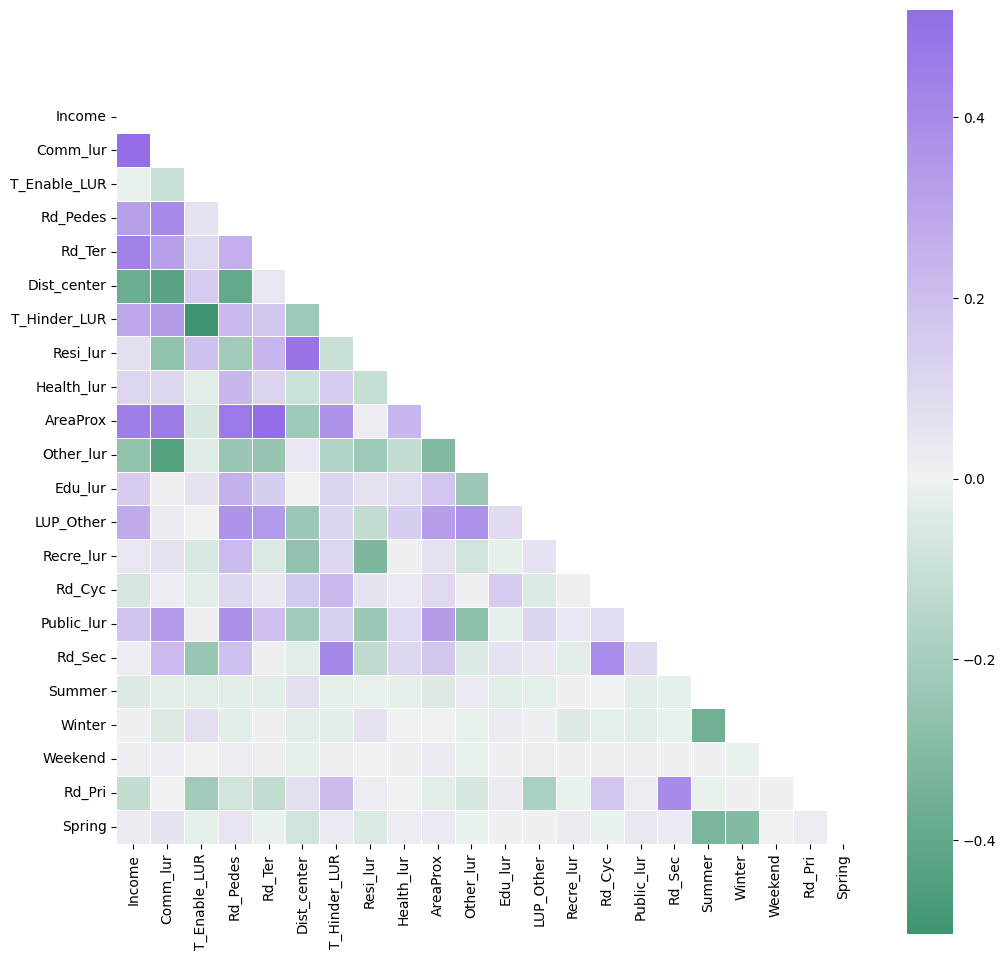

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features to remove for better correlation (< 70% )
sorted_feature_names.remove('LUP_Comm')
sorted_feature_names.remove('LUP_Health')
sorted_feature_names.remove('LUP_Public')
sorted_feature_names.remove('LUP_Edu')
sorted_feature_names.remove('LUP_Recre')
sorted_feature_names.remove('LUP_Resi')
sorted_feature_names.remove('T_Hinder_POI')
sorted_feature_names.remove('T_Other_POI')
sorted_feature_names.remove('T_Other_LUR')
sorted_feature_names.remove('T_Enable_POI')

features_1 = sorted_feature_names
corr = data[features_1].corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True,linewidths=.5, cbar_kws={"shrink": 1})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 10)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 10)

In [45]:
print(len(features_1))
X = data[features_1].values
y = data['trip_count'].values
features_1

22


['Income',
 'Comm_lur',
 'T_Enable_LUR',
 'Rd_Pedes',
 'Rd_Ter',
 'Dist_center',
 'T_Hinder_LUR',
 'Resi_lur',
 'Health_lur',
 'AreaProx',
 'Other_lur',
 'Edu_lur',
 'LUP_Other',
 'Recre_lur',
 'Rd_Cyc',
 'Public_lur',
 'Rd_Sec',
 'Summer',
 'Winter',
 'Weekend',
 'Rd_Pri',
 'Spring']

In [46]:
selected_columns = ['Comm_lur', 'Income', 'T_Enable_LUR', 'Rd_Pedes', 'Rd_Ter', 'T_Hinder_LUR', 'Resi_lur', 'Health_lur',
                    'AreaProx', 'Other_lur', 'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc', 'Public_lur',
                    'Rd_Sec', 'Summer', 'Winter', 'Weekend', 'Rd_Pri', 'Spring','Dist_center','trip_count']

dependent_var = 'trip_count'
independent_vars = selected_columns.copy()
independent_vars.remove(dependent_var)

# Split the data into independent and dependent variables
X = data[independent_vars]
y = data[dependent_var]

x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [47]:
# Define the best hyperparameters found by GridSearchCV
best_params = {'max_depth': 25, 'max_features': 20, 'n_estimators': 250}

# Create a random forest regressor with the best hyperparameters
model = RandomForestRegressor(**best_params, random_state=42)

# Fit the regressor to the training data
model.fit(x_train, y_train)

# Predict on the test data
y_pred = model.predict(x_test)

In [48]:
# Perform 10-fold cross-validation
cv_results = cross_validate(model, X, y, cv=10, scoring='r2', return_estimator=True)

# Extract the estimators from each fold
estimators = cv_results['estimator']

# Calculate the R2 score for each fold using the test data
test_scores = []
for i, estimator in enumerate(estimators):
    y_pred = estimator.predict(x_test)
    score = r2_score(y_test, y_pred)
    test_scores.append(score)
    print(f"Fold {i+1} R2 score: {score:.2f}")

# Print the average R2 score across all folds for the test data
print(f"Mean test R2 CVscore: {np.mean(test_scores):.2f}")

Fold 1 R2 score: 0.98
Fold 2 R2 score: 0.98
Fold 3 R2 score: 0.97
Fold 4 R2 score: 0.97
Fold 5 R2 score: 0.92
Fold 6 R2 score: 0.81
Fold 7 R2 score: 0.94
Fold 8 R2 score: 0.94
Fold 9 R2 score: 0.97
Fold 10 R2 score: 0.97
Mean test R2 CVscore: 0.94


In [49]:
importances = model.feature_importances_
print(features_1, importances)

['Income', 'Comm_lur', 'T_Enable_LUR', 'Rd_Pedes', 'Rd_Ter', 'Dist_center', 'T_Hinder_LUR', 'Resi_lur', 'Health_lur', 'AreaProx', 'Other_lur', 'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc', 'Public_lur', 'Rd_Sec', 'Summer', 'Winter', 'Weekend', 'Rd_Pri', 'Spring'] [0.15289817 0.1259358  0.02155691 0.17706917 0.00758819 0.00986941
 0.02959467 0.00241678 0.04777178 0.03116858 0.00560842 0.00835153
 0.01022089 0.00576464 0.01107023 0.0077462  0.13788511 0.01582528
 0.1533464  0.00220386 0.00310031 0.03300768]


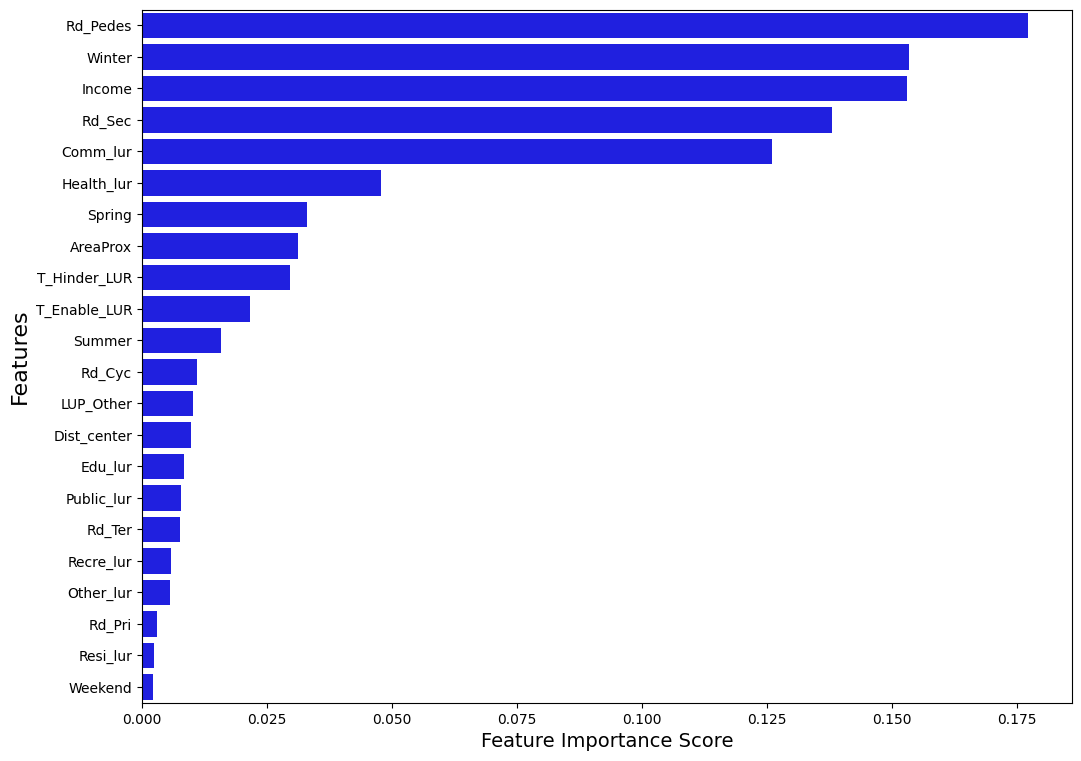

In [50]:
# Get feature importances and plot them
result1 = pd.DataFrame({"features":features_1, "importances":model.feature_importances_})
result = result1.sort_values(by='importances',ascending=False)
plt.figure(figsize=(12,9))
sns.barplot(x=result['importances'], y=result['features'], color='blue')
plt.xlabel('Feature Importance Score', fontsize='14')
plt.ylabel('Features', fontsize='16')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [51]:
df = data[selected_columns]
df.head()

,Comm_lur,Income,T_Enable_LUR,Rd_Pedes,Rd_Ter,T_Hinder_LUR,Resi_lur,Health_lur,AreaProx,Other_lur,Edu_lur,LUP_Other,Recre_lur,Rd_Cyc,Public_lur,Rd_Sec,Summer,Winter,Weekend,Rd_Pri,Spring,Dist_center,trip_count
0,0.086472,157.0,1.000010,1439.900816,2082.456266,0.000010,0.052529,0.00001,345964.219364,0.697177,0.000010,30.0,0.163862,419.872391,0.000010,0.000000,0.0,1.0,0.0,0.0,0.0,5946.427499,7
1,0.000010,177.0,1.000010,1065.726327,2166.682187,0.000010,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.000010,0.000000,0.0,1.0,0.0,0.0,0.0,5685.068161,34
2,0.000010,177.0,1.000010,1065.726327,2166.682187,0.000010,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.000010,0.000000,0.0,1.0,1.0,0.0,0.0,5685.068161,18
3,0.244780,75.0,0.182869,711.715352,1324.557886,0.817151,0.363444,0.00001,406313.760336,0.175444,0.000010,12.0,0.154628,1320.841234,0.061754,1111.702762,0.0,1.0,0.0,0.0,0.0,4472.135955,35
4,0.000010,90.0,1.000010,348.374199,2986.375820,0.000010,0.520001,0.00001,110894.679720,0.445502,0.000010,91.0,0.034527,1583.108650,0.000010,93.634200,0.0,1.0,0.0,0.0,0.0,4418.144407,26


In [52]:
from scipy.stats import pearsonr
correlation_matrix = df.corr()
p_value_matrix = np.zeros(correlation_matrix.shape)

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        corr, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
        correlation_matrix.iloc[i, j] = corr
        correlation_matrix.iloc[j, i] = corr
        p_value_matrix[i, j] = p_value
        p_value_matrix[j, i] = p_value

p_value_df = pd.DataFrame(p_value_matrix, columns=correlation_matrix.columns, index=correlation_matrix.index)

correlation_matrix = correlation_matrix.round(3)
p_value_df = p_value_df.round(3)
p_value_df = p_value_df.applymap(lambda x: '***' if x < 0.001 else '**' if x < 0.05 else '*' if x < 0.1 else ' ns')

combined_table = correlation_matrix.astype(str) + p_value_df
combined_table

,Comm_lur,Income,T_Enable_LUR,Rd_Pedes,Rd_Ter,T_Hinder_LUR,Resi_lur,Health_lur,AreaProx,Other_lur,Edu_lur,LUP_Other,Recre_lur,Rd_Cyc,Public_lur,Rd_Sec,Summer,Winter,Weekend,Rd_Pri,Spring,Dist_center,trip_count
Comm_lur,1.0***,0.538***,-0.166***,0.394***,0.298***,0.329***,-0.372***,-0.076***,0.439***,-0.467***,-0.171***,-0.034*,-0.09***,0.005 ns,0.168***,0.203***,-0.025 ns,-0.04**,0.019 ns,-0.029 ns,0.051**,-0.39***,0.454***
Income,0.538***,1.0***,-0.055**,0.456***,0.394***,0.217***,-0.192***,-0.047**,0.349***,-0.265***,-0.077***,0.202***,-0.056**,-0.092***,0.095***,0.007 ns,-0.034*,0.002 ns,0.016 ns,-0.159***,0.031*,-0.378***,0.415***
T_Enable_LUR,-0.166***,-0.055**,1.0***,-0.024 ns,0.028 ns,-0.641***,0.213***,-0.047**,-0.161***,-0.014 ns,0.032*,-0.015 ns,-0.071***,-0.089***,0.002 ns,-0.245***,-0.028 ns,0.074***,-0.001 ns,-0.228***,-0.023 ns,0.162***,-0.109***
Rd_Pedes,0.394***,0.456***,-0.024 ns,1.0***,0.259***,0.192***,-0.308***,0.111***,0.427***,-0.262***,0.088***,0.352***,0.056**,0.032*,0.196***,0.139***,-0.033*,-0.019 ns,0.022 ns,-0.102***,0.048**,-0.405***,0.45***
Rd_Ter,0.298***,0.394***,0.028 ns,0.259***,1.0***,0.148***,0.141***,0.035*,0.467***,-0.279***,-0.102***,0.222***,-0.184***,0.032*,0.047**,-0.042**,-0.03*,0.01 ns,0.021 ns,-0.12***,-0.006 ns,0.1***,0.19***
T_Hinder_LUR,0.329***,0.217***,-0.641***,0.192***,0.148***,1.0***,-0.179***,0.096***,0.364***,-0.18***,0.004 ns,0.039**,0.018 ns,0.219***,0.021 ns,0.356***,-0.012 ns,-0.036**,0.015 ns,0.18***,0.034*,-0.225***,0.226***
Resi_lur,-0.372***,-0.192***,0.213***,-0.308***,0.141***,-0.179***,1.0***,-0.121***,-0.124***,-0.259***,-0.086***,-0.183***,-0.313***,-0.02 ns,-0.262***,-0.143***,-0.009 ns,0.076***,-0.008 ns,-0.023 ns,-0.068***,0.511***,-0.223***
Health_lur,-0.076***,-0.047**,-0.047**,0.111***,0.035*,0.096***,-0.121***,1.0***,0.071***,-0.08***,-0.009 ns,0.006 ns,-0.055**,-0.001 ns,-0.004 ns,0.052**,-0.012 ns,0.004 ns,0.006 ns,0.167***,0.012 ns,-0.031*,0.005 ns
AreaProx,0.439***,0.349***,-0.161***,0.427***,0.467***,0.364***,-0.124***,0.071***,1.0***,-0.308***,-0.037**,0.18***,-0.093***,0.111***,0.178***,0.204***,-0.039**,-0.004 ns,0.022 ns,-0.005 ns,0.029 ns,-0.198***,0.379***
Other_lur,-0.467***,-0.265***,-0.014 ns,-0.262***,-0.279***,-0.18***,-0.259***,-0.08***,-0.308***,1.0***,-0.192***,0.327***,-0.102***,-0.049**,-0.228***,-0.08***,0.044**,-0.013 ns,-0.014 ns,-0.05**,-0.01 ns,0.032*,-0.249***


In [53]:
os.chdir('C:\\Users\\omkarp\\Downloads\\DataFinal\\')
combined_table.to_csv('correlation.csv', index=True)

In [54]:
columns_to_select = ['FID_grid'] + [col for col in selected_columns]
df = data[columns_to_select]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FID_grid      2990 non-null   int64  
 1   Comm_lur      2990 non-null   float64
 2   Income        2990 non-null   float64
 3   T_Enable_LUR  2990 non-null   float64
 4   Rd_Pedes      2990 non-null   float64
 5   Rd_Ter        2990 non-null   float64
 6   T_Hinder_LUR  2990 non-null   float64
 7   Resi_lur      2990 non-null   float64
 8   Health_lur    2990 non-null   float64
 9   AreaProx      2990 non-null   float64
 10  Other_lur     2990 non-null   float64
 11  Edu_lur       2990 non-null   float64
 12  LUP_Other     2990 non-null   float64
 13  Recre_lur     2990 non-null   float64
 14  Rd_Cyc        2990 non-null   float64
 15  Public_lur    2990 non-null   float64
 16  Rd_Sec        2990 non-null   float64
 17  Summer        2990 non-null   float64
 18  Winter        2990 non-null 

## Final grid with data

In [55]:
grid = gpd.read_file('GridSto.shp').reset_index(drop=False)
grid = grid.rename(columns={'index':'FID_grid'})
grid = grid.drop(columns=['OBJECTID', 'INPUT_FID', 'NEAR_FID','Empl', 'Pop22', 'Net_Inc', 'DISTANCE','TVeh'])
grid.head(2)

,FID_grid,geometry
0,0,"POLYGON ((667401.864 6575792.310, 667401.864 6..."
1,1,"POLYGON ((667801.864 6575792.310, 667801.864 6..."


In [56]:
grid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID_grid  917 non-null    int64   
 1   geometry  917 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 14.5 KB


In [57]:
Gdata = df.merge(grid, on='FID_grid', how='left')
Gdata.update(Gdata.groupby('FID_grid')['geometry'].ffill())
Gdata = GeoDataFrame(Gdata, geometry='geometry')
Gdata.head(2)

,FID_grid,Comm_lur,Income,T_Enable_LUR,Rd_Pedes,Rd_Ter,T_Hinder_LUR,Resi_lur,Health_lur,AreaProx,Other_lur,Edu_lur,LUP_Other,Recre_lur,Rd_Cyc,Public_lur,Rd_Sec,Summer,Winter,Weekend,Rd_Pri,Spring,Dist_center,trip_count,geometry
0,9,0.086472,157.0,1.00001,1439.900816,2082.456266,0.00001,0.052529,0.00001,345964.219364,0.697177,0.000010,30.0,0.163862,419.872391,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5946.427499,7,"POLYGON ((671001.864 6575792.310, 671001.864 6..."
1,10,0.000010,177.0,1.00001,1065.726327,2166.682187,0.00001,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.00001,0.0,0.0,1.0,0.0,0.0,0.0,5685.068161,34,"POLYGON ((671401.864 6575792.310, 671401.864 6..."


In [58]:
crs = Gdata.crs
crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - onshore and offshore.
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Distance Matrix

In [59]:
#extract the centroids
Gdata["Centroids"] = Gdata.geometry.centroid
distances = Gdata.rename_axis('Orig').Centroids.apply(lambda x: Gdata.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
distances['Dist']=distances['Dist'].astype(int)
distances.head()

,Orig,Dest,Dist
0,0,0,0
1,0,1,400
2,0,2,400
3,0,3,3200
4,0,4,3600


In [60]:
dfd = pd.pivot_table(distances, values ="Dist", index="Orig", columns = "Dest",aggfunc=np.sum, margins=True)
dfd

Dest         0         1         2         3         4         5         6  \
Orig                                                                         
0            0       400       400      3200      3600      3600      4000   
1          400         0         0      2800      3200      3200      3600   
2          400         0         0      2800      3200      3200      3600   
3         3200      2800      2800         0       400       400       800   
4         3600      3200      3200       400         0         0       400   
...        ...       ...       ...       ...       ...       ...       ...   
2986     10522     10469     10469     10522     10590     10590     10673   
2987     10522     10469     10469     10522     10590     10590     10673   
2988     10522     10469     10469     10522     10590     10590     10673   
2989     10590     10522     10522     10469     10522     10522     10590   
All   19162582  18651071  18651071  16899305  16925685  16925685  17026953   

Dest         7         8         9        10        11        12        13  \
Orig                                                                         
0         4000      4400      4400      4800      4800      4800      4800   
1         3600      4000      4000      4400      4400      4400      4400   
2         3600      4000      4000      4400      4400      4400      4400   
3          800      1200      1200      1600      1600      1600      1600   
4          400       800       800      1200      1200      1200      1200   
...        ...       ...       ...       ...       ...       ...       ...   
2986     10673     10770     10770     10881     10881     10881     10881   
2987     10673     10770     10770     10881     10881     10881     10881   
2988     10673     10770     10770     10881     10881     10881     10881   
2989     10590     10673     10673     10770     10770     10770     10770   
All   17026953  17205160  17205160  17462145  17462145  17462145  17462145   

Dest        14        15        16        17        18        19        20  \
Orig                                                                         
0         4800      5200      5200      5200       894       894       565   
1         4400      4800      4800      4800      1264      1264       894   
2         4400      4800      4800      4800      1264      1264       894   
3         1600      2000      2000      2000      4019      4019      3622   
4         1200      1600      1600      1600      4418      4418      4019   
...        ...       ...       ...       ...       ...       ...       ...   
2986     10881     11005     11005     11005     10283     10283     10198   
2987     10881     11005     11005     11005     10283     10283     10198   
2988     10881     11005     11005     11005     10283     10283     10198   
2989     10770     10881     10881     10881     10384     10384     10283   
All   17462145  17800874  17800874  17800874  19527174  19527174  18878093   

Dest        21        22        23        24        25        26        27  \
Orig                                                                         
0          565       400       400       565       565      3224      3224   
1          894       565       565       400       400      2828      2828   
2          894       565       565       400       400      2828      2828   
3         3622      3224      3224      2828      2828       400       400   
4         4019      3622      3622      3224      3224       565       565   
...        ...       ...       ...       ...       ...       ...       ...   
2986     10198     10127     10127     10071     10071     10127     10127   
2987     10198     10127     10127     10071     10071     10127     10127   
2988     10198     10127     10127     10071     10071     10127     10127   
2989     10283     10198     10198     10127     10127     10071     10071   
All   18878093  182

In [61]:
dfd.to_csv('distance_matrix.csv', index=True)

In [62]:
Gdata['x'] = Gdata['Centroids'].x
Gdata['y'] = Gdata['Centroids'].y
Gdata = Gdata.drop(['Centroids'], axis=1)
Gdata = Gdata.rename(columns={'T_Enable_LUR':'T_Enable','T_Hinder_LUR':'T_Hinder'})
Gdata.head()

,FID_grid,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,Resi_lur,Health_lur,AreaProx,Other_lur,Edu_lur,LUP_Other,Recre_lur,Rd_Cyc,Public_lur,Rd_Sec,Summer,Winter,Weekend,Rd_Pri,Spring,Dist_center,trip_count,geometry,x,y
0,9,0.086472,157.0,1.000010,1439.900816,2082.456266,0.000010,0.052529,0.00001,345964.219364,0.697177,0.000010,30.0,0.163862,419.872391,0.000010,0.000000,0.0,1.0,0.0,0.0,0.0,5946.427499,7,"POLYGON ((671001.864 6575792.310, 671001.864 6...",671201.8641,6.575992e+06
1,10,0.000010,177.0,1.000010,1065.726327,2166.682187,0.000010,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.000010,0.000000,0.0,1.0,0.0,0.0,0.0,5685.068161,34,"POLYGON ((671401.864 6575792.310, 671401.864 6...",671601.8641,6.575992e+06
2,10,0.000010,177.0,1.000010,1065.726327,2166.682187,0.000010,0.299365,0.00001,660104.976827,0.403699,0.163545,32.0,0.133431,1449.850557,0.000010,0.000000,0.0,1.0,1.0,0.0,0.0,5685.068161,18,"POLYGON ((671401.864 6575792.310, 671401.864 6...",671601.8641,6.575992e+06
3,17,0.244780,75.0,0.182869,711.715352,1324.557886,0.817151,0.363444,0.00001,406313.760336,0.175444,0.000010,12.0,0.154628,1320.841234,0.061754,1111.702762,0.0,1.0,0.0,0.0,0.0,4472.135955,35,"POLYGON ((674201.864 6575792.310, 674201.864 6...",674401.8641,6.575992e+06
4,18,0.000010,90.0,1.000010,348.374199,2986.375820,0.000010,0.520001,0.00001,110894.679720,0.445502,0.000010,91.0,0.034527,1583.108650,0.000010,93.634200,0.0,1.0,0.0,0.0,0.0,4418.144407,26,"POLYGON ((674601.864 6575792.310, 674601.864 6...",674801.8641,6.575992e+06


In [63]:
os.chdir('C:\\Users\\omkarp\\Downloads\\DataFinal\\')
Gdata.to_csv('Stodata.csv', index=False)

In [64]:
output_shapefile = 'GdfSto.shp'
Gdata.to_file(output_shapefile, driver='ESRI Shapefile')
print(f"Shapefile saved: {output_shapefile}")

Shapefile saved: GdfSto.shp


In [65]:
Gdata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID_grid     2990 non-null   int64   
 1   Comm_lur     2990 non-null   float64 
 2   Income       2990 non-null   float64 
 3   T_Enable     2990 non-null   float64 
 4   Rd_Pedes     2990 non-null   float64 
 5   Rd_Ter       2990 non-null   float64 
 6   T_Hinder     2990 non-null   float64 
 7   Resi_lur     2990 non-null   float64 
 8   Health_lur   2990 non-null   float64 
 9   AreaProx     2990 non-null   float64 
 10  Other_lur    2990 non-null   float64 
 11  Edu_lur      2990 non-null   float64 
 12  LUP_Other    2990 non-null   float64 
 13  Recre_lur    2990 non-null   float64 
 14  Rd_Cyc       2990 non-null   float64 
 15  Public_lur   2990 non-null   float64 
 16  Rd_Sec       2990 non-null   float64 
 17  Summer       2990 non-null   float64 
 18  Winter       2990 no